<a href="https://colab.research.google.com/github/johnbeasley1998/NINEworkshop/blob/master/VLASS_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Galaxy Classification**
* We will start from scratch with 4 galaxy classifications. This data is not curated
* 4 categories: diffuse, disturbed, multiple, single
* Images are monocromatic 960x960 pi
* Series of 921 600 px

Steps:
1. Download data
2. Mount our Colab Drive
3. Load the data
4. Run classifier

Data is structured as:
* ./images
  * ./train
    * ./shape1
    * ./shape2
    * ./shape3
  * ./valid
    * ./shape1
    * ./shape2
    * ./shape3

In [ ]:
#Methods to read data
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.autograd import Variable




In [ ]:
# Define transform and load datasets
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset = ImageFolder('/srv/data/my_shared_data_folder/v3/train/', simple_transform)
validset = ImageFolder('/srv/data/my_shared_data_folder/v3/valid/', simple_transform)


In [ ]:
print(trainset)
type(trainset)

print(validset)
type(validset)

Dataset ImageFolder
    Number of datapoints: 344
    Root location: /content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v1/train
Dataset ImageFolder
    Number of datapoints: 125
    Root location: /content/drive/My Drive/NINE/Collab/PyTorch/PyTorch - ImageClassifier/GalaxyClassifier/images/v1/valid


torchvision.datasets.folder.ImageFolder

In [ ]:
trainset.class_to_idx

{'diffuse': 0, 'disturbed': 1, 'multiple': 2, 'single': 3}

In [ ]:
validset.class_to_idx

{'diffuse': 0, 'disturbed': 1, 'multiple': 2, 'single': 3}

In [ ]:
for key, value in trainset.class_to_idx.items():
  print('Class is: ', key, ', Index is: ', value)

Class is:  diffuse , Index is:  0
Class is:  disturbed , Index is:  1
Class is:  multiple , Index is:  2
Class is:  single , Index is:  3


**Next steps**
1. Data is already loaded into 2 variables: trainset and validset
2. Identify the modules you will need for the classifier


In [ ]:
import torch #Main torch library
import torch.nn as nn #Neural Network module, we will build our class
import torchvision #Used earlier for data import
import torchvision.transforms as transforms
import torch.nn.functional as F

We need to display some sample images. It's best to import with matplotlib. Also import numpy for good measure.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Build the image display function
#Let's use our previous example as a boiler plate
#Lets use the PyTorch built in display method, using the python imaging Library
#PIL or Pillow
from PIL import Image
import random

def imshow(img):
  img = img/2+0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


[93, 172, 77]
2 2 1


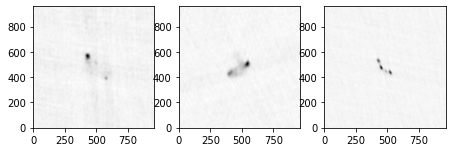

In [ ]:
#Get random images
rand_array = []

for i in range(3):
  rand_image_index = random.randint(0, len(trainset))
  rand_array.append(rand_image_index)

print(rand_array)

#This can be improved with another image show method
fig = plt.figure(figsize=(10,5), facecolor='white', edgecolor='black')
ax1 = fig.add_subplot(141)
ax1.imshow(trainset[rand_array[0]][0], origin='lower')

ax2 = fig.add_subplot(142)
ax2.imshow(trainset[rand_array[1]][0], origin='lower')

ax3 = fig.add_subplot(143)
ax3.imshow(trainset[rand_array[2]][0], origin='lower')
print(trainset[rand_array[0]][1], trainset[rand_array[1]][1], trainset[rand_array[2]][1])

**Define NN**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #in channel
    #Two convolution kernels
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(3380, 50) #Transformation variable
    # 921 600
    self.fc2 = nn.Linear(50, 4)

#Forward method is basically a recursion relationship
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(x.size(0), -1) #Resize
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training) #Inherited from nn.Module
    x = F.relu(self.fc2(x))
    
    return F.log_softmax(x, dim=1)

model = Net()

In [ ]:
type(model)

__main__.Net

In [ ]:
print(model) #Print out model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3380, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
)


In [ ]:
# Define an optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.05) #Brian used momentum=5
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.05
    nesterov: False
    weight_decay: 0
)

To use the NN class we need to define an optimizer.
In order to utilize the new neural network class, we need to define an optimizer with torch.optim

In [ ]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
  if phase == 'training':
    model.train()
  elif phase == 'validation':
    model.eval()
    volatile=True
  running_loss = 0.0
  running_correct = 0.0

  for batch_idx, (data, target) in enumerate(data_loader):
    data, target = Variable(data, volatile), Variable(target)
  
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)

    running_loss += F.nll_loss(output, target, size_average=False).data
    preds = output.data.max(dim=1, keepdim=True)[1] 
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()

    if phase == 'training':
      loss.backward()
      optimizer.step()
  loss = running_loss / len(data_loader.dataset)
  accuracy = 100. * running_correct / len(data_loader.dataset)

  print(f'{phase} loss is {loss} and {phase} accuracy is {running_correct} / {len(data_loader.dataset)} = {accuracy}')
  return loss, accuracy


In [ ]:
#Define loss function and accuracy
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

train_data_loader = torch.utils.data.DataLoader(trainset,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(validset,batch_size=32,num_workers=3,shuffle=True)

In [ ]:
for epoch in range(1,4):
  #train model
  #validate
  #update lists
  #Make simple graph of loss function
  epoch_loss, epoch_accuracy = fit(epoch, model, train_data_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_data_loader, phase='validation')
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

In [ ]:
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label='training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label='validation loss')
plt.legend()
plt.show()